# General Relativity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import ipywidgets

def gamma(b):
    return 1/np.sqrt(1-b**2)

### Hw1.3

How does an isotropically emitting gamma source look like from the point of view of a moving observer?

In [2]:
@np.vectorize
def theta(theta_prime,beta):
    """
    Returns the angle of the radiation,
    emitted by the moving observer O' at an angle theta_prime,
    as seen by the stationary observer O,
    if the relative speed between O and O' is beta*c.
    """

    s = np.sin(theta_prime)/(gamma(beta)*(1 + np.cos(theta_prime)*beta))
    c = (np.cos(theta_prime) + beta)/(1 + np.cos(theta_prime)*beta)
    if s >= 0:
        return np.arccos(c)
    else:
        return 2*np.pi - np.arccos(c)

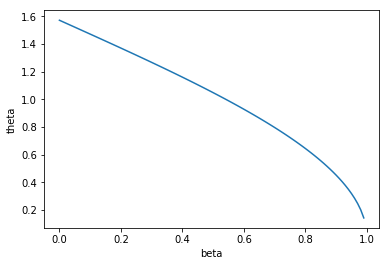

In [3]:
# varying beta

theta_prime = np.pi/2


betas = np.arange(0,1,0.01)

thetas = [theta(theta_prime=theta_prime,beta=b) for b in betas]
thetas = np.array(thetas)

plt.figure()
plt.plot(betas,thetas)
plt.xlabel('beta')
plt.ylabel('theta')
plt.show()


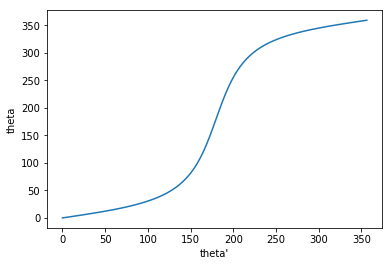

In [4]:
# varying theta_prime

beta = 0.9


theta_primes = np.arange(0,2*np.pi,2*np.pi/100)

thetas = [theta(theta_prime=t,beta=beta) for t in theta_primes]
thetas = np.array(thetas)

plt.figure()
plt.plot(theta_primes*180/np.pi,thetas*180/np.pi)
plt.xlabel('theta\'')
plt.ylabel('theta')
plt.show()

In [5]:
# multiple rays

n_rays = 16

theta_primes = np.arange(0,2*np.pi,2*np.pi/n_rays)

def plot_rays(beta):

    thetas = [theta(theta_prime=t,beta=beta) for t in theta_primes]
    thetas = np.array(thetas)

    plt.figure()
    for t in thetas:
        plt.plot([0,np.cos(t)],[0,np.sin(t)])
    plt.show()

ipywidgets.interact(plot_rays, beta = (0,0.99,0.01))

<function __main__.plot_rays>

In [6]:
# Intensity

n_rays = 16
amp_factor = 1000

theta_primes = np.arange(0,np.pi,np.pi/(amp_factor*n_rays))
theta_scan = np.arange(0,np.pi+np.pi/n_rays,np.pi/n_rays)


def plot_intensity(beta):

    thetas = [theta(theta_prime=t,beta=beta) for t in theta_primes]
    thetas = np.array(thetas)

    intensity = np.zeros_like(theta_scan)

    j = 0
    last_i = 0
    for i,t in enumerate(thetas):
        if j >= len(intensity):
                print('error')
                break
        if t > theta_scan[j]:
            #print(i)
            intensity[j] = i - last_i
            last_i = i
            j += 1
    intensity[-1] = n_rays*amp_factor - last_i
    2
    intensity /= 1.*n_rays*amp_factor

    plt.figure()
    plt.plot(theta_scan[1:]*180/np.pi,intensity[1:])
    plt.xlabel('theta')
    plt.ylabel('normalized intensity')
    plt.title('angular spectrum')
    plt.show()

#plot_intensity(0.3)

ipywidgets.interact(plot_intensity, beta = (0,0.99,0.01))

<function __main__.plot_intensity>

In [7]:
# accounting for 3-dimensionality

n_rays = 16
amp_factor = 1000

theta_primes = np.arange(0,np.pi,np.pi/(amp_factor*n_rays))
theta_scan = np.arange(0,np.pi+np.pi/n_rays,np.pi/n_rays)


def plot_intensity(beta):

    thetas = [theta(theta_prime=t,beta=beta) for t in theta_primes]
    thetas = np.array(thetas)

    intensity = np.zeros_like(theta_scan)

    j = 0
    for i,t in enumerate(thetas):
        if j >= len(intensity):
                print('error')
                break
        intensity[j] += (0.00001 + np.sin(theta_primes[i]))/(0.0001 + np.sin(theta_scan[j]))
        if t > theta_scan[j]:
            #print(i)
            j += 1

    s = sum(intensity)
    print(intensity,s)
    intensity /= 1.*s

    plt.figure()
    plt.semilogy(theta_scan[1:]*180/np.pi,intensity[1:])
    plt.xlabel('theta')
    plt.ylabel('normalized intensity')
    plt.title('angular spectrum')
    plt.show()

# plot_intensity(0.)

ipywidgets.interact(plot_intensity, beta = (0,0.99,0.01))

<function __main__.plot_intensity>

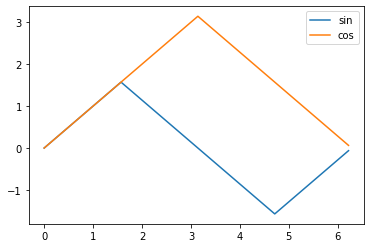

In [8]:
# just to clarify how (arc)cos and (arc)sin work

theta_primes = np.arange(0,2*np.pi,2*np.pi/100)

plt.figure()
plt.plot(theta_primes,np.arcsin(np.sin(theta_primes)), label = 'sin')
plt.plot(theta_primes,np.arccos(np.cos(theta_primes)), label = 'cos')
plt.legend()
plt.show()


In [8]:
# Analytical solution to the intensity problem:
# assume in its own frame the source emits energy isotropically:
# what is the angular distribution seen by the observer?
# It will be cylindrically symmetric of course: what is the distribution wrt theta?

import sympy as sp
sp.init_printing()

v = sp.symbols('v', real=True)
gamma_sp = 1 / sp.sqrt(1-v**2)

theta_prime = sp.symbols('theta_prime', real=True)

# angle in the observer frame O
theta_orig = sp.atan(1/gamma_sp/(1/sp.tan(theta_prime) + v/sp.sin(theta_prime)))

# distribution means the derivative of theta in O wrt theta in O'
distribution = sp.diff(theta_orig, theta_prime)
# taking account of the size of the spherical portion.
# the absolute value is needed because of some issues with the arccosine and arccsine
# which are difficult to deal with in sympy
distribution_3d = sp.Abs(distribution * sp.sin(theta_orig) / sp.sin(theta_prime))

In [9]:
def plot_distribution(relative_velocity):

    # take the generic distributions and insert the actual velocity
    new_distribution = distribution.subs(v, relative_velocity)
    new_distribution_3d = distribution_3d.subs(v, relative_velocity)

    x = sp.symbols('x')

    # we make functions from the sympy relations, the inverse is
    # inserted because we want to plot d (theta_prime) / d (theta)
    f = sp.lambdify(x, 1/new_distribution.subs(theta_prime, x), 'numpy')
    f_3d = sp.lambdify(x, 1/new_distribution_3d.subs(theta_prime, x), 'numpy')

    theta_primes = np.linspace(1e-10, np.pi-1e-10)
    thetas = theta(theta_primes, relative_velocity)

    plt.ylabel("dtheta_prime/dtheta")
    plt.xlabel("theta")
    plt.semilogy(thetas, f(theta_primes), label="2d")
    plt.semilogy(thetas, f_3d(theta_primes), label="3d")
    plt.legend()
    plt.suptitle(f"relative velocity = {relative_velocity:.4f}")
    plt.show()

def log_plot(log_velocity):
    plot_distribution(1-10**(-log_velocity))

# ipywidgets.interact(plot_distribution, relative_velocity=(0,0.99,0.01), continuous_update=False)
ipywidgets.interact(log_plot, log_velocity=(0,2.5,0.05), continuous_update=False)

<function __main__.log_plot>